In [706]:
from bs4 import BeautifulSoup
import random
import requests
import pandas as pd
import numpy as np
import re
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import classification_report, accuracy_score

### Функции вывода

In [707]:
def print_arrays_lengths():
    print("Lengths of arrays:")
    print("Titles:", len(titles))
    print("Genres:", len(genres))
    print("Descriptions:", len(descriptions))

In [708]:
def print_arrays():
    print("Lengths of arrays:")
    print("Titles:", titles)
    print("Genres:", genres)
    print("Descriptions:", descriptions)

### Объявляем массивы

In [709]:
titles = []
genres = []
descriptions = []

### Задаем настройки для парсинга

In [710]:
num_pages = 100

counter = 1
pg_counter=1
proxies_list = ['10.1.7.70:8000', '10.1.7.70:8001', '10.1.7.70:8002']
proxies = {
    'http': random.choice(proxies_list)
}

## Парсинг

Парсим данные

In [711]:
for page in range(1, num_pages + 1):
    url = f"https://www.rarefilmfinder.com/successfulmovies.php?page={page}"
    response = requests.get(url, proxies=proxies)

    print("LIST" + ' ' + str(pg_counter) + "--------------------------------------")
    counter=1
    pg_counter+=1

    soup_list = BeautifulSoup(response.text, 'html.parser')

    rows = soup_list.find_all('tr')

    for row in rows:
        title_tag = row.find('a', href=True)
        if title_tag:
            title = title_tag.find('img')['title']
            titles.append(title)

        link = row.find('a')
        if link and 'href' in link.attrs:
            href = link['href']
            movie_id = href.split('id=')[-1]

        url_details = f"https://www.rarefilmfinder.com/movie.php?id={movie_id}"
        response_details = requests.get(url_details, proxies=proxies)

        print(counter)
        counter+=1

        soup_details = BeautifulSoup(response_details.text, 'html.parser')

        descriptions.append(np.nan)
        genres.append(np.nan)

        descriptions_div = soup_details.find('div', id='movie_review_en')
        if descriptions_div:
          value = descriptions_div.text.strip()
          descriptions[-1] = value

        genre_label = soup_details.find(string="Genre:")
        if genre_label:
            genre_value = None
            next_string = genre_label
            while True:
                next_string = next_string.find_next(string=True)
                if not next_string:
                    break
                text_candidate = next_string.strip()
                if text_candidate and text_candidate != "Genre:":
                    genre_value = text_candidate
                    break

            if genre_value:
                genres[-1] = genre_value

tabel = pd.DataFrame({
    'Title': titles,
    'Genre': genres,
    'Descriptions': descriptions
})

Сохраняем спаршенные данные в .csv файл

In [712]:
tabel.to_csv('data2.csv', index=False)

Смотрим что спарсили

In [713]:
print_arrays_lengths()
print_arrays()

Lengths of arrays:
Titles: 0
Genres: 0
Descriptions: 0
Lengths of arrays:
Titles: []
Genres: []
Descriptions: []


In [714]:
titles_cp = titles
descriptions_cp = descriptions

## Задача: определить основной жанр по описанию

### Указываем путь к файлу

In [715]:
common_file_path= "data2.csv"

### Читаем датасет

In [716]:
common_df = pd.read_csv(common_file_path)
print(common_df.head())

                                        Title  \
0                                      Avatar   
1                           Avengers: Endgame   
2                    Avatar: The Way of Water   
3                                     Titanic   
4  Star Wars: Episode VII - The Force Awakens   

                                   Genre  \
0  Action / Adventure / Fantasy / Sci-Fi   
1    Action / Adventure / Drama / Sci-Fi   
2  Action / Adventure / Fantasy / Sci-Fi   
3                        Drama / Romance   
4  Action / Adventure / Fantasy / Sci-Fi   

                                        Descriptions  
0  A paraplegic Marine dispatched to the moon Pan...  
1  The grave course of events set in motion by Th...  
2  Jake Sully lives with his newfound family form...  
3  A seventeen-year-old aristocrat falls in love ...  
4  30 years after the defeat of Darth Vader and t...  


In [717]:
common_df = common_df.drop_duplicates()

### Отделяем нужные данные

In [718]:
common_df = common_df[["Title", "Genre", "Descriptions"]]


In [719]:

df = common_df

df["Genre"] = df["Genre"].astype(str).str.split("/").str[0].str.strip()

print(df.columns.tolist())
print(df.head())


['Title', 'Genre', 'Descriptions']
                                        Title   Genre  \
0                                      Avatar  Action   
1                           Avengers: Endgame  Action   
2                    Avatar: The Way of Water  Action   
3                                     Titanic   Drama   
4  Star Wars: Episode VII - The Force Awakens  Action   

                                        Descriptions  
0  A paraplegic Marine dispatched to the moon Pan...  
1  The grave course of events set in motion by Th...  
2  Jake Sully lives with his newfound family form...  
3  A seventeen-year-old aristocrat falls in love ...  
4  30 years after the defeat of Darth Vader and t...  


In [720]:
df = df.drop_duplicates()
df = df.dropna()

Жанры

Genre
Action         512
Comedy         292
Drama          182
Animation      150
Adventure      133
Horror          82
Biography       60
Crime           57
Mystery          9
Fantasy          7
Sci-Fi           5
Thriller         3
Family           2
nan              2
Documentary      1
Musical          1
Western          1
Name: count, dtype: int64


Text(0, 0.5, 'Кол-во категорий')

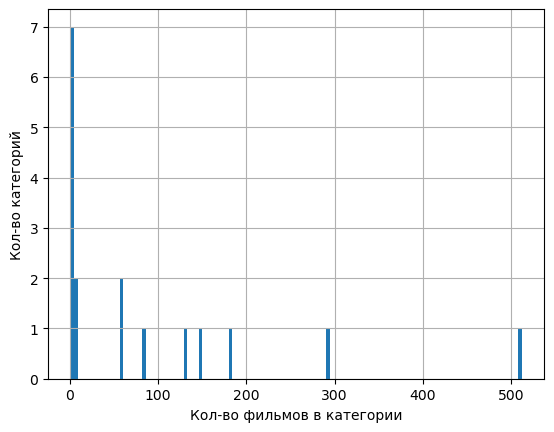

In [721]:
category = df.value_counts('Genre')
print(category)
category.hist(bins=120, rwidth=0.9)
plt.xlabel('Кол-во фильмов в категории')
plt.ylabel('Кол-во категорий')

Чистим данные

In [722]:
category_counts = df['Genre'].value_counts()
top_3_categories = category_counts.head(3).index.tolist()

print(f"3 самых популярных категорий:")
print(category_counts.head(3))

df = df[df['Genre'].isin(top_3_categories)]

print(f"\nКоличество фильмов после фильтрации: {len(df)}")
print(f"\nРаспределение по категориям:")
print(df['Genre'].value_counts())

3 самых популярных категорий:
Genre
Action    512
Comedy    292
Drama     182
Name: count, dtype: int64

Количество фильмов после фильтрации: 986

Распределение по категориям:
Genre
Action    512
Comedy    292
Drama     182
Name: count, dtype: int64


In [723]:
df = df[~df['Genre'].isin(['War', 'Music', 'Short'])]


посмотрим, сколько слов в текстах

<Axes: >

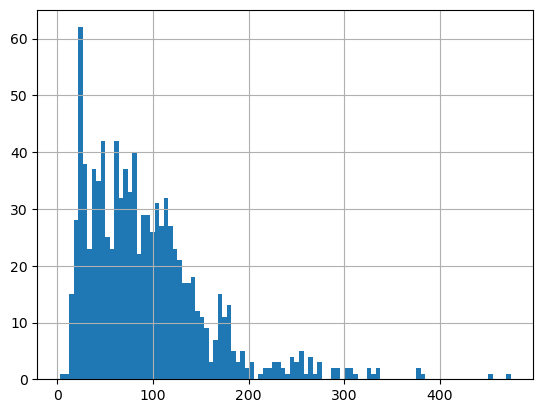

In [724]:
words = df['Descriptions'].fillna('').apply(lambda text: len(text.split()))
words.hist(bins=100)

In [725]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.pre_tokenizer = Whitespace()

corpus = df['Descriptions'].tolist()
tokenizer.train_from_iterator(corpus, trainer)

def preprocess_text(text):
    encoded = tokenizer.encode(text)
    return ' '.join(encoded.tokens)

df['processed_Descriptions'] = df['Descriptions'].apply(preprocess_text)
df[['Descriptions', 'processed_Descriptions']].sample(10)

,Descriptions,processed_Descriptions
246,"When John Connor (Jason Clarke), leader of the...","When John Connor ( Jason Clarke ), leader of t..."
191,Over 10 years have passed since the first robo...,Over 10 years have passed since the first robo...
541,Through Abstergo a company that creates a revo...,Through Abstergo a company that creates a revo...
1056,Benjamin has lost his wife. In a bid to start ...,Benjamin has lost his wife . In a bid to start...
1159,"In December 1975, George and Kathy Lutz along ...","In December 1975 , George and Kathy Lutz along..."
40,A lonely Hawaiian girl befriends a runaway ali...,A lonely Hawaiian girl befriends a runaway ali...
210,"At the story's heart is Caesar (Andy Serkis), ...",At the story ' s heart is Caesar ( Andy Serkis...
367,On the day that Hurricane Katrina hits New Orl...,On the day that Hurricane Katrina hits New Orl...
1184,Against the backdrop of a war between humans a...,Against the backdrop of a war between humans a...
43,"The evil Trade Federation, led by Nute Gunray ...","The evil Trade Federation , led by Nute Gunray..."


In [726]:
def plot_clusters_tsne(data, fig_size=(12, 8), model_name="all-MiniLM-L6-v2", seed=42):
    model = SentenceTransformer(model_name)
    data = data.reset_index(drop=True)
    text_embeddings = np.array(model.encode(data['processed_Descriptions'], convert_to_numpy=True))

    n_samples = text_embeddings.shape[0]

    tsne_model = TSNE(n_components=2, random_state=seed, perplexity=30, max_iter=1000)
    reduced_features = tsne_model.fit_transform(text_embeddings)
    data['tsne_x'] = reduced_features[:, 0]
    data['tsne_y'] = reduced_features[:, 1]

    plt.figure(figsize=fig_size)
    unique_genres = data['Genre'].unique()

    for genre in unique_genres:
        subset = data[data['Genre'] == genre]
        plt.scatter(
            subset['tsne_x'],
            subset['tsne_y'],
            label=f'Жанр: {genre}',
            alpha=0.7,
            s=50
        )

    plt.title('Кластеризация текстов с помощью t-SNE')
    plt.xlabel('Первая компонента t-SNE')
    plt.ylabel('Вторая компонента t-SNE')
    plt.legend(title='Жанры', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

Вызов функции

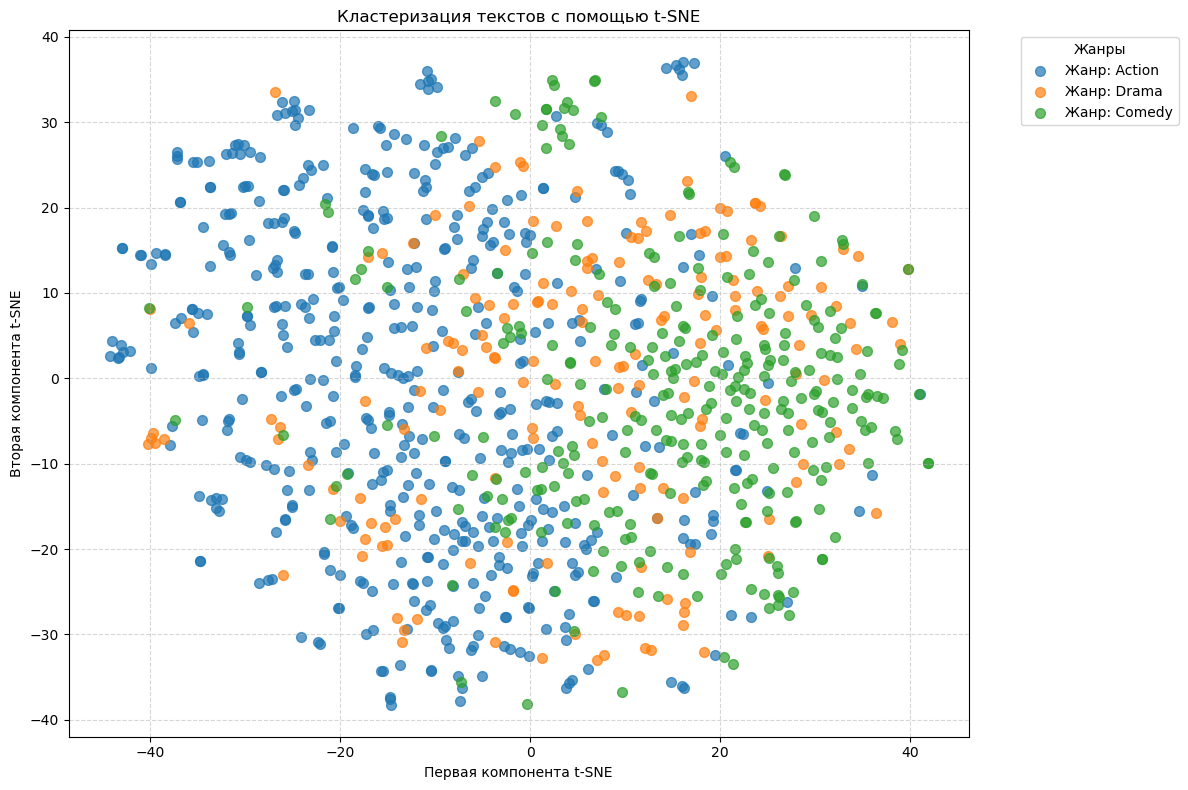

In [727]:
plot_clusters_tsne(df)
df.drop(columns=['tsne_x', 'tsne_y'], errors='ignore', inplace=True)

In [728]:
print("Загрузка модели SentenceTransformer...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
print("Модель загружена!")

label_encoder = LabelEncoder()

texts = df['processed_Descriptions']
categories = df['Genre']

texts_train, texts_valid, categories_train, categories_valid = train_test_split(
    texts, categories, test_size=0.3, random_state=42
)

print("\nСоздание embeddings для обучающей выборки...")
X_train = np.array(embedding_model.encode(texts_train.tolist(), convert_to_numpy=True, show_progress_bar=True))
y_train = label_encoder.fit_transform(categories_train)

print("Создание embeddings для валидационной выборки...")
X_valid = np.array(embedding_model.encode(texts_valid.tolist(), convert_to_numpy=True, show_progress_bar=True))
y_valid = label_encoder.transform(categories_valid)

print(f"\nTrain: {X_train.shape}, {y_train.shape}")
print(f"Valid: {X_valid.shape}, {y_valid.shape}")
print(f"Размерность embeddings: {X_train.shape[1]} (вместо {1000} в Bag of Words)")


unique_classes, class_counts = np.unique(y_train, return_counts=True)
total_samples = len(y_train)
class_weights_balanced = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weights = np.sqrt(class_weights_balanced)
class_weights = class_weights / class_weights.mean()
class_weights = torch.tensor(class_weights, dtype=torch.float32)

print(f"\nРаспределение классов:")
for cls, count, weight in zip(unique_classes, class_counts, class_weights):
    print(f"  Класс {cls}: {count} образцов, вес = {weight:.4f}")
print(f"\nСредний вес: {class_weights.mean():.4f}")

Загрузка модели SentenceTransformer...
Модель загружена!

Создание embeddings для обучающей выборки...


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Создание embeddings для валидационной выборки...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]


Train: (690, 384), (690,)
Valid: (296, 384), (296,)
Размерность embeddings: 384 (вместо 1000 в Bag of Words)

Распределение классов:
  Класс 0: 367 образцов, вес = 0.7362
  Класс 1: 198 образцов, вес = 1.0023
  Класс 2: 125 образцов, вес = 1.2615

Средний вес: 1.0000


In [729]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attention = nn.Linear(hidden_dim, 1)
        
    def forward(self, lstm_output):
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        context = torch.sum(attention_weights * lstm_output, dim=1)
        return context, attention_weights


class ImprovedLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(ImprovedLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.input_projection = nn.Linear(input_size, hidden_size)
        self.bn_input = nn.BatchNorm1d(hidden_size)
        
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        self.attention = Attention(hidden_size * 2)
        self.bn_lstm = nn.BatchNorm1d(hidden_size * 2)

        fc_hidden = hidden_size // 2
        self.fc1 = nn.Linear(hidden_size * 2, fc_hidden)
        self.bn_fc = nn.BatchNorm1d(fc_hidden)
        self.relu = nn.ReLU()
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout * 0.9)
        
        self.fc2 = nn.Linear(fc_hidden, output_size)
        
    def forward(self, x):
        x = self.input_projection(x)
        x = self.bn_input(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = x.unsqueeze(1)
        
        lstm_out, (hidden, cell) = self.lstm(x)

        
        context, attention_weights = self.attention(lstm_out)

        context = self.bn_lstm(context)
        context = self.dropout1(context)
        
        context = self.fc1(context)
        context = self.bn_fc(context)
        context = self.relu(context)
        context = self.dropout1(context)
        
        output = self.fc2(context)
        return output

In [730]:
class TextData(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.texts[index], self.labels[index]

### Создание обучающего и валидационного наборов данных

In [731]:
train_data = TextData(X_train, y_train)
valid_data = TextData(X_valid, y_valid)

### Создание загрузчиков данных

In [732]:
train_loader = DataLoader(train_data, batch_size=96, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=96, shuffle=False)

Добавил LSTM

In [733]:
embedding_dim = X_train.shape[1]
hidden_dim = 96
num_layers = 2
num_classes = len(np.unique(y_train))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

model = ImprovedLSTMClassifier(
    input_size=embedding_dim,
    hidden_size=hidden_dim,
    num_layers=num_layers,
    output_size=num_classes,
    dropout=0.7
).to(device)

print(f"\nАрхитектура модели:")
print(model)
print(f"\nПараметры модели:")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Всего параметров: {total_params:,}")
print(f"  Обучаемых параметров: {trainable_params:,}")

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))


optimizer = Adam(model.parameters(), lr=0.001, weight_decay=5e-3)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=1,
    verbose=True,
    min_lr=1e-6
)

print(f"\nНачальный learning rate: {optimizer.param_groups[0]['lr']}")
print("Learning rate scheduler настроен (ReduceLROnPlateau)")

Используемое устройство: cpu

Архитектура модели:
ImprovedLSTMClassifier(
  (input_projection): Linear(in_features=384, out_features=96, bias=True)
  (bn_input): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(96, 96, num_layers=2, batch_first=True, dropout=0.7, bidirectional=True)
  (attention): Attention(
    (attention): Linear(in_features=192, out_features=1, bias=True)
  )
  (bn_lstm): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=192, out_features=48, bias=True)
  (bn_fc): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.7, inplace=False)
  (dropout2): Dropout(p=0.63, inplace=False)
  (fc2): Linear(in_features=48, out_features=3, bias=True)
)

Параметры модели:
  Всего параметров: 418,948
  Обучаемых параметров: 418,948

Начальный learning rate: 0.001
Learning rate scheduler настроен (ReduceLROnPlat

C:\Users\HONOR\miniconda3\envs\workspace\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [734]:
num_epochs = 25
best_valid_loss = float('inf')
patience = 4
patience_counter = 0
best_model_state = None

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    cumulative_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

    for batch_texts, batch_labels in progress_bar:
        batch_texts, batch_labels = batch_texts.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        predictions = model(batch_texts)
        loss_value = criterion(predictions, batch_labels)
        loss_value.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        cumulative_loss += loss_value.item()
        progress_bar.set_postfix(loss=cumulative_loss / len(train_loader))
    
    train_loss = cumulative_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for batch_texts, batch_labels in valid_loader:
            batch_texts, batch_labels = batch_texts.to(device), batch_labels.to(device)
            predictions = model(batch_texts)
            loss_value = criterion(predictions, batch_labels)
            valid_loss += loss_value.item()
    
    valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(valid_loss)
    
    scheduler.step(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"  ✓ Улучшение! Valid loss: {valid_loss:.4f}")
    else:
        patience_counter += 1
        print(f"  ✗ Нет улучшения. Patience: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print(f"\nEarly stopping на эпохе {epoch + 1}")
        model.load_state_dict(best_model_state)
        break

print(f"\nЛучшая валидационная loss: {best_valid_loss:.4f}")

Epoch 1/25: 100%|██████████| 8/8 [00:00<00:00, 59.20it/s, loss=1.21] 


  ✓ Улучшение! Valid loss: 1.0946


Epoch 2/25: 100%|██████████| 8/8 [00:00<00:00, 61.65it/s, loss=1.17]


  ✓ Улучшение! Valid loss: 1.0941


Epoch 3/25: 100%|██████████| 8/8 [00:00<00:00, 61.24it/s, loss=1.13] 


  ✗ Нет улучшения. Patience: 1/4


Epoch 4/25: 100%|██████████| 8/8 [00:00<00:00, 60.15it/s, loss=1.12] 


  ✓ Улучшение! Valid loss: 1.0936


Epoch 5/25: 100%|██████████| 8/8 [00:00<00:00, 57.03it/s, loss=1.08] 


  ✓ Улучшение! Valid loss: 1.0906


Epoch 6/25: 100%|██████████| 8/8 [00:00<00:00, 56.60it/s, loss=1.09] 


  ✓ Улучшение! Valid loss: 1.0801


Epoch 7/25: 100%|██████████| 8/8 [00:00<00:00, 70.11it/s, loss=1.07] 


  ✓ Улучшение! Valid loss: 1.0503


Epoch 8/25: 100%|██████████| 8/8 [00:00<00:00, 61.09it/s, loss=0.996]


  ✓ Улучшение! Valid loss: 1.0025


Epoch 9/25: 100%|██████████| 8/8 [00:00<00:00, 56.88it/s, loss=1.02] 


  ✓ Улучшение! Valid loss: 0.9396


Epoch 10/25: 100%|██████████| 8/8 [00:00<00:00, 65.71it/s, loss=0.941]


  ✓ Улучшение! Valid loss: 0.8931


Epoch 11/25: 100%|██████████| 8/8 [00:00<00:00, 59.07it/s, loss=0.901]


  ✓ Улучшение! Valid loss: 0.8535


Epoch 12/25: 100%|██████████| 8/8 [00:00<00:00, 52.57it/s, loss=0.884]


  ✓ Улучшение! Valid loss: 0.8362


Epoch 13/25: 100%|██████████| 8/8 [00:00<00:00, 61.07it/s, loss=0.837]


  ✓ Улучшение! Valid loss: 0.8221


Epoch 14/25: 100%|██████████| 8/8 [00:00<00:00, 59.26it/s, loss=0.79] 


  ✓ Улучшение! Valid loss: 0.8190


Epoch 15/25: 100%|██████████| 8/8 [00:00<00:00, 56.12it/s, loss=0.768]


  ✗ Нет улучшения. Patience: 1/4


Epoch 16/25: 100%|██████████| 8/8 [00:00<00:00, 67.57it/s, loss=0.742]


  ✗ Нет улучшения. Patience: 2/4


Epoch 17/25: 100%|██████████| 8/8 [00:00<00:00, 73.07it/s, loss=0.729]


  ✓ Улучшение! Valid loss: 0.8170


Epoch 18/25: 100%|██████████| 8/8 [00:00<00:00, 56.14it/s, loss=0.717]


  ✓ Улучшение! Valid loss: 0.8047


Epoch 19/25: 100%|██████████| 8/8 [00:00<00:00, 59.14it/s, loss=0.735]


  ✗ Нет улучшения. Patience: 1/4


Epoch 20/25: 100%|██████████| 8/8 [00:00<00:00, 69.14it/s, loss=0.694]


  ✗ Нет улучшения. Patience: 2/4


Epoch 21/25: 100%|██████████| 8/8 [00:00<00:00, 52.64it/s, loss=0.686]


  ✗ Нет улучшения. Patience: 3/4


Epoch 22/25: 100%|██████████| 8/8 [00:00<00:00, 51.55it/s, loss=0.651]


  ✗ Нет улучшения. Patience: 4/4

Early stopping на эпохе 22

Лучшая валидационная loss: 0.8047


In [735]:
def assess_model_performance(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch_texts, batch_labels in data_loader:
            batch_texts, batch_labels = batch_texts.to(device), batch_labels.to(device)
            model_outputs = model(batch_texts)
            _, predicted_classes = torch.max(model_outputs, dim=1)
            predictions.extend(predicted_classes.cpu().numpy())
            true_labels.extend(batch_labels.cpu().numpy())

    report_summary = classification_report(true_labels, predictions, digits=4)
    overall_accuracy = accuracy_score(true_labels, predictions)
    return report_summary, overall_accuracy

## Оценка производительности на обучающем наборе данных

In [736]:
training_report, training_accuracy = assess_model_performance(model, train_loader, device)
print("Training Metrics:")
print(training_report)
print(f"Training Accuracy: {training_accuracy:.4f}")

Training Metrics:
              precision    recall  f1-score   support

           0     0.9310    0.9564    0.9435       367
           1     0.6510    0.9798    0.7823       198
           2     1.0000    0.1200    0.2143       125

    accuracy                         0.8116       690
   macro avg     0.8607    0.6854    0.6467       690
weighted avg     0.8632    0.8116    0.7652       690

Training Accuracy: 0.8116


## Оценка производительности на валидационном наборе данных

In [ ]:
validation_report, validation_accuracy = assess_model_performance(model, valid_loader, device)
print("\nValidation Metrics:")
print(validation_report)
print(f"Validation Accuracy: {validation_accuracy:.4f}")


Validation Metrics:
              precision    recall  f1-score   support

           0     0.8267    0.8552    0.8407       145
           1     0.6000    0.8936    0.7179        94
           2     1.0000    0.1053    0.1905        57

    accuracy                         0.7230       296
   macro avg     0.8089    0.6180    0.5830       296
weighted avg     0.7881    0.7230    0.6765       296

Validation Accuracy: 0.7230
